Updating fastai...
Done.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,top_3_accuracy,time
0,1.100460,2.149361,0.381200,0.678500,03:50
1,0.770211,0.744177,0.740300,0.937800,03:50
2,0.565428,0.630093,0.782500,0.951500,03:50


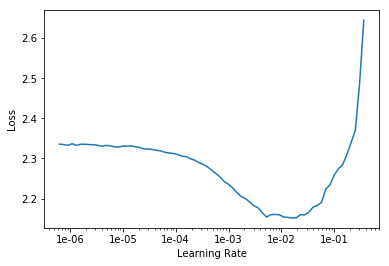

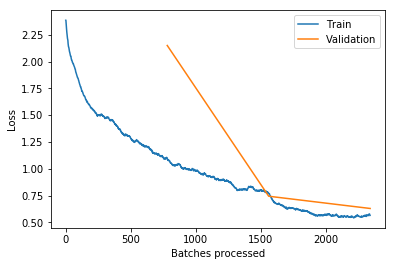

In [2]:
!curl -s https://course.fast.ai/setup/colab | bash
import fastai
from fastai.vision import *
from torch import nn
from fastai.metrics import top_k_accuracy

path = untar_data(URLs.CIFAR)
data = ImageDataBunch.from_folder(path, valid='test')

class block(nn.Module):
    def __init__(self, n_in, n_out, two_d=True):
        super().__init__()
        self.op = nn.Conv2d(n_in, n_out, 3) if two_d else nn.Linear(n_in, n_out)
        self.bn = nn.BatchNorm2d(n_out) if two_d else nn.BatchNorm1d(n_out)
    def forward(self, x):
        x = self.op(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

arch = SequentialEx(
    block(3,32),
    block(32,32),
    nn.MaxPool2d(2),
    block(32,32),
    block(32,32),
    nn.MaxPool2d(2),
    Flatten(),
    block(800, 800, False),
    block(800, 800, False),
    nn.Linear(800, 10)
)

def top_3_accuracy(preds, targs): return top_k_accuracy(preds, targs, 3)

learn = Learner(data, arch, metrics=[accuracy, top_3_accuracy])

def train(epochs=3, max_lr=3e-3, find_lr=True, plot_losses=True, save_model=False):
    if find_lr:
        learn.lr_find()
        fig = learn.recorder.plot(return_fig=True)
        fig.savefig('lr_find.png')

    learn.fit_one_cycle(epochs, max_lr)
    learn.summary()

    if plot_losses:
        fig = learn.recorder.plot_losses(return_fig=True)
        fig.savefig('losses.png')

    if save_model:
        loss, top_1, top_3 = learn.validate()
        learn.save(f'{epochs}_{max_lr}_{loss:.2f}_{top_1:.2f}_{top_3:.2f}')

train()
